# Test BO with a trained NN as Prior

In [23]:
from ea_train import ARESEACheetah
import botorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from gpytorch.means.mean import Mean
import numpy as np
from gym.wrappers import FilterObservation, FlattenObservation, RescaleAction, TimeLimit
from gym.spaces.utils import unflatten
from bayesopt import calculate_objective

import matplotlib.pyplot as plt

## Gather some training dataset for NN

In [164]:
n_steps = 50000
n_evalsteps = 10000
config = {
        "action_mode": "direct_unidirectional_quads",
        "beam_distance_ord": 2,
        "gamma": 0.99,
        "filter_action": None,
        "filter_observation": None,
        "frame_stack": None,
        "incoming_mode": "random",
        "incoming_values": np.array(
        [1.18e08, 0, 0, 0, 0, 5e-05, 6e-06, 4e-04, 3e-05, 9e-06, 7e-04],
        dtype="float32",
    ),
        "log_beam_distance": False,
        "magnet_init_mode": "constant",
        "magnet_init_values": np.zeros(5),
        "max_misalignment": 5e-4,
        "max_quad_delta": 72,
        "max_steerer_delta": 6.1782e-3,
        "misalignment_mode": "constant",
        "misalignment_values": np.zeros(8),
        "n_envs": 40,
        "normalize_beam_distance": True,
        "normalize_observation": True,
        "normalize_reward": True,
        "rescale_action": (-1, 1),
        "reward_mode": "differential",
        "sb3_device": "auto",
        "target_beam_mode": "constant",
        "target_beam_values": np.zeros(4),
        "target_mu_x_threshold": 3e-6,
        "target_mu_y_threshold": 3e-6,
        "target_sigma_x_threshold": 3e-6,  # 20e-6 m are close to screen resolution
        "target_sigma_y_threshold": 3e-6,
        "threshold_hold": 3,
        "time_limit": n_steps,
        "vec_env": "subproc",
        "w_beam": 1.0,
        "w_done": 10.0,
        "w_mu_x": 1.0,
        "w_mu_x_in_threshold": 0.0,
        "w_mu_y": 1.0,
        "w_mu_y_in_threshold": 0.0,
        "w_on_screen": 0.0,
        "w_sigma_x": 1.0,
        "w_sigma_x_in_threshold": 0.0,
        "w_sigma_y": 1.0,
        "w_sigma_y_in_threshold": 0.0,
        "w_time": 0.0,
    }

In [165]:
env = ARESEACheetah(
    action_mode=config["action_mode"],
    incoming_mode=config["incoming_mode"],
    incoming_values=config["incoming_values"],
    magnet_init_mode=config["magnet_init_mode"],
    magnet_init_values=config["magnet_init_values"],
    misalignment_mode=config["misalignment_mode"],
    misalignment_values=config["misalignment_values"],
    reward_mode=config["reward_mode"],
    target_beam_mode=config["target_beam_mode"],
    target_beam_values=config["target_beam_values"],
    target_mu_x_threshold=config["target_mu_x_threshold"],
    target_mu_y_threshold=config["target_mu_y_threshold"],
    target_sigma_x_threshold=config["target_sigma_x_threshold"],
    target_sigma_y_threshold=config["target_sigma_y_threshold"],
    threshold_hold=config["threshold_hold"],
    w_done=config["w_done"],
    w_mu_x=config["w_mu_x"],
    w_mu_x_in_threshold=config["w_mu_x_in_threshold"],
    w_mu_y=config["w_mu_y"],
    w_mu_y_in_threshold=config["w_mu_y_in_threshold"],
    w_on_screen=config["w_on_screen"],
    w_sigma_x=config["w_sigma_x"],
    w_sigma_x_in_threshold=config["w_sigma_x_in_threshold"],
    w_sigma_y=config["w_sigma_y"],
    w_sigma_y_in_threshold=config["w_sigma_y_in_threshold"],
    w_time=config["w_time"],
)
env = TimeLimit(env, config["time_limit"])
if config["filter_observation"] is not None:
    env = FilterObservation(env, config["filter_observation"])
env = FlattenObservation(env)
if config["rescale_action"] is not None:
    env = RescaleAction(
        env, config["rescale_action"][0], config["rescale_action"][1]
    )

In [166]:
# # Gather Training data
# np.random.seed(1)
# observation = env.reset()
# done = False
# actions = np.random.random(size=(n_steps,5)) *2 - 1

# objs = np.zeros(n_steps)
# beams = np.zeros((n_steps,4))
# for i, action in enumerate(actions):
#     observation, reward, done, info = env.step(action)
#     obs = unflatten(env.unwrapped.observation_space, observation)
#     cb = obs["beam"]
#     tb = obs["target"]
#     obj = -np.log(np.mean(np.abs(cb - tb)))
#     objs[i] = obj
#     beams[i] = cb

# # Save the data for further usage
# with open("nn_for_bo/train_data.npz", "wb") as f:
#     np.savez(f ,action=actions, beam=beams, obj=objs)

In [167]:
# # Gather Evaluation data
# np.random.seed(2)
# observation = env.reset()
# done = False
# actions = np.random.random(size=(n_evalsteps,5)) *2 - 1

# objs = np.zeros(n_evalsteps)
# beams = np.zeros((n_evalsteps,4))
# for i, action in enumerate(actions):
#     observation, reward, done, info = env.step(action)
#     obs = unflatten(env.unwrapped.observation_space, observation)
#     cb = obs["beam"]
#     tb = obs["target"]
#     obj = -np.log(np.mean(np.abs(cb - tb)))
#     objs[i] = obj
#     beams[i] = cb

# # Save the data for further usage
# with open("nn_for_bo/evaluation_data.npz", "wb") as f:
#     np.savez(f ,action=actions, beam=beams, obj=objs)

In [20]:
# Save the data for further usage
# with open("nn_for_bo/train_data.npz", "wb") as f:
#     np.savez(f ,x=actions, y=objs)

In [168]:
# print(objs.max(),actions[np.argmax(objs),:])

8.714292526245117 [-0.65109003  0.42485252  0.02563338  0.4462136   0.04448002]


## Train a NN (Ver1)

Predicts directly the logmae, doesn't work so well

In [68]:
class SimpleNNforARESEA(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(5,8,bias=True,),
            nn.Tanh(),
            nn.Linear(8,8),
            nn.Tanh(),
            nn.Linear(8,8),
            nn.Tanh(),
            nn.Linear(8,1)
        )

    def forward(self, x):
        return self.layers(x)

class CheetahSingleObjDataset(Dataset):
    def __init__(self, datafile) -> None:
        super().__init__()
        with np.load(datafile) as data:
            x = data["action"]
            y = data["obj"]
        self.X = torch.tensor(x, dtype=torch.float32)
        self.Y = torch.tensor(y, dtype=torch.float32)

        # output transform
        self.Y = self.Y / 20
    
    def __len__(self):
        return self.Y.shape[0]
    
    def __getitem__(self, index):
        return self.X[index,:], self.Y[index]


In [185]:

def train(dataloader, model, loss_fn, optimizer):
    #size = len(dataloader.dataset)
    train_epoch_loss = 0
    model.train()
    for batch, (X, y) in enumerate(dataloader):

        # Compute prediction error
        y_pred = model(X)
        loss = loss_fn(y_pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        train_epoch_loss += loss.item()
    return train_epoch_loss

def evaluate(dataloader, model, loss_fn,):
    total_error = 0
    model.eval()
    for (X,y) in dataloader:
        # Compute prediction error
        y_pred = model(X)
        total_error += loss_fn(y_pred, y).item()

    return total_error  

In [69]:
training_data = CheetahSingleObjDataset(datafile="nn_for_bo/train_data.npz")
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)


In [70]:
# Training
# model = SimpleNNforARESEA()
# loss_fn = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# n_epoch = 100
# losses = np.zeros(n_epoch)
# for t in range(n_epoch):
    
#     epoch_loss = train(train_dataloader, model, loss_fn, optimizer)
#     # # cal validation loss
#     # val_loss = evaluate(validataion_dataloader, model, loss_fn)
#     losses[t] = epoch_loss
#     if t % (n_epoch // 10) == 0:
#         print(f"Epoch {t+1}, loss = {epoch_loss}\n-------------------------------")
# print("Done!")


Epoch 1, loss = 73.93974793329835
-------------------------------
Epoch 11, loss = 32.74412417784333
-------------------------------
Epoch 21, loss = 24.471498724538833
-------------------------------
Epoch 31, loss = 19.558906579390168
-------------------------------
Epoch 41, loss = 16.91475791891571
-------------------------------
Epoch 51, loss = 15.386437991866842
-------------------------------
Epoch 61, loss = 14.476690315874293
-------------------------------
Epoch 71, loss = 13.900222622323781
-------------------------------
Epoch 81, loss = 13.464640313526616
-------------------------------
Epoch 91, loss = 13.096624728175811
-------------------------------
Done!


In [71]:
# torch.save(model.state_dict(), f"nn_for_bo/v1_model_weights.pth")
# torch.save(model, f"nn_for_bo/v1_model.pth")

## Train a NN to predict out beam (Ver2)

In [182]:
class SimpleBeamPredictNN(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(5,8,bias=True,),
            nn.Tanh(),
            nn.Linear(8,8),
            nn.Tanh(),
            nn.Linear(8,8),
            nn.Tanh(),
            nn.Linear(8,4)
        )

    def forward(self, x):
        return self.layers(x)

class CheetahBeamDataset(Dataset):
    def __init__(self, datafile) -> None:
        super().__init__()
        with np.load(datafile) as data:
            x = data["action"]
            y = data["beam"]
        self.X = torch.tensor(x, dtype=torch.float32)
        self.Y = torch.tensor(y, dtype=torch.float32)

        # output transform
        # self.Y = self.Y * 1e3
    
    def __len__(self):
        return self.Y.shape[0]
    
    def __getitem__(self, index):
        return self.X[index,:], self.Y[index,:]

In [186]:
training_data = CheetahBeamDataset(datafile="nn_for_bo/train_data.npz")
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)

validation_data = CheetahBeamDataset(datafile="nn_for_bo/evaluation_data.npz")
validation_dataloader = DataLoader(training_data, batch_size=64, shuffle=False)

In [187]:
# Training
model = SimpleBeamPredictNN()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

n_epoch = 100
losses = np.zeros(n_epoch)
for t in range(n_epoch):
    
    epoch_loss = train(train_dataloader, model, loss_fn, optimizer)
    # cal validation loss
    val_loss = evaluate(validation_dataloader, model, loss_fn)
    losses[t] = epoch_loss
    if t % (n_epoch // 10) == 0:
        print(f"Epoch {t+1}, loss = {epoch_loss}, val_loss = {val_loss}\n-------------------------------")
print("Done!")

Epoch 1, loss = 1.1992168795004545, val_loss = 0.047345352582851774
-------------------------------
Epoch 11, loss = 0.004465262321446062, val_loss = 0.004195128832861883
-------------------------------
Epoch 21, loss = 0.0021646657428391336, val_loss = 0.0025365580104335095
-------------------------------
Epoch 31, loss = 0.0016688991468072345, val_loss = 0.0015760233541186608
-------------------------------
Epoch 41, loss = 0.0014578159560869608, val_loss = 0.001312688166422049
-------------------------------
Epoch 51, loss = 0.0012166712547241332, val_loss = 0.0012292809469727217
-------------------------------
Epoch 61, loss = 0.0010228210167610996, val_loss = 0.0008561271588405361
-------------------------------
Epoch 71, loss = 0.000921864522240412, val_loss = 0.0012660078535873254
-------------------------------
Epoch 81, loss = 0.0008374960533501508, val_loss = 0.000956497441677584
-------------------------------
Epoch 91, loss = 0.000804629614208352, val_loss = 0.0007889733246

In [190]:
# torch.save(model.state_dict(), f"nn_for_bo/v2_model_weights.pth")
# torch.save(model, f"nn_for_bo/v2_model.pth")

In [191]:
# let's see some examples

data = np.load("nn_for_bo/train_data.npz")

In [196]:
model.eval()
model.double()
print(model(torch.tensor(data["action"][:10])).detach() - data["beam"][:10])

tensor([[-3.9719e-04,  4.3851e-04,  2.5164e-04,  1.1538e-03],
        [-1.8923e-04, -8.4991e-04, -7.6285e-04,  6.7058e-04],
        [-2.1896e-05,  2.9048e-04,  2.3160e-04,  2.2695e-03],
        [-1.3258e-04, -9.8997e-04, -6.0385e-04, -7.8915e-05],
        [-5.2720e-04,  5.4195e-04, -3.4585e-04,  2.8383e-04],
        [-2.5366e-04,  7.0576e-05, -3.4005e-03,  1.7102e-04],
        [ 2.3597e-04,  6.7884e-04, -3.3157e-05, -1.1924e-04],
        [-2.6534e-04,  1.9463e-03, -1.4571e-03, -7.2525e-04],
        [ 5.4191e-04,  2.2747e-03, -3.4320e-04,  3.9201e-04],
        [-4.3876e-04,  6.1707e-04,  5.6904e-04, -3.9463e-04]],
       dtype=torch.float64)


## Try to Use the NN as Prior for BO

In [198]:
class CheetahNNPrior(Mean):
    def __init__(self):
        super().__init__()
        self.mlp = SimpleNNforARESEA()
        self.mlp.load_state_dict(torch.load(f'nn_for_bo/v1_model_weights.pth'))
        self.mlp.eval()
        self.mlp.double() # for double input from GPyTorch
    
    def forward(self,x):
        return self.mlp(x).squeeze() * 20

class BeamNNPrior(Mean):
    def __init__(self, target):
        super().__init__()
        self.mlp = SimpleBeamPredictNN()
        self.mlp.load_state_dict(torch.load(f'nn_for_bo/v2_model_weights.pth'))
        self.mlp.eval()
        self.mlp.double() # for double input from GPyTorch
        self.target = target
    
    def forward(self,x):
        logmae = -torch.log(torch.mean(torch.abs(self.mlp(x) - self.target), dim=-1))
        return logmae

In [120]:
from utils import FilterAction, RecordEpisode
from eval_bo_sim import convert_incoming_from_problem, convert_misalignments_from_problem, convert_target_from_problem
from bayesopt import calculate_objective, get_new_bound, get_next_samples, scale_action
import json

In [200]:
with open("problems.json", "r") as f:
    problems = json.load(f)
problem = problems[0]

config = {
        "action_mode": "direct_unidirectional_quads",
        "filter_action": None,
        "filter_observation": None,  # ["beam", "magnets", "target"],
        "incoming_mode": "constant",
        "incoming_values": convert_incoming_from_problem(problem),
        "magnet_init_mode": "constant",
        "magnet_init_values": np.array([10, -10, 0, 10, 0]),
        "max_steps": 150,
        "misalignment_mode": "constant",
        "misalignment_values": convert_misalignments_from_problem(problem),
        "rescale_action": (-1, 1),
        "reward_mode": "differential",
        "target_beam_mode": "constant",
        "target_beam_values": convert_target_from_problem(problem),
        "target_mu_x_threshold": 20e-6,
        "target_mu_y_threshold": 20e-6,
        "target_sigma_x_threshold": 20e-6,
        "target_sigma_y_threshold": 20e-6,
        "threshold_hold": 5,
        "w_done": 0.0,
        "w_mu_x": 1.0,
        "w_mu_x_in_threshold": 0.0,
        "w_mu_y": 1.0,
        "w_mu_y_in_threshold": 0.0,
        "w_on_screen": 10.0,
        "w_sigma_x": 1.0,
        "w_sigma_x_in_threshold": 0.0,
        "w_sigma_y": 1.0,
        "w_sigma_y_in_threshold": 0.0,
        "w_time": 0.0,
        "obj_function": "logmae",
        "acquisition": "EI",
        "init_x": None,
        "init_samples": 10,
        "stepsize": 0.1,
    }

    # Create the environment
env = ARESEACheetah(
    action_mode=config["action_mode"],
    incoming_mode=config["incoming_mode"],
    incoming_values=config["incoming_values"],
    magnet_init_mode=config["magnet_init_mode"],
    magnet_init_values=config["magnet_init_values"],
    misalignment_mode=config["misalignment_mode"],
    misalignment_values=config["misalignment_values"],
    reward_mode=config["reward_mode"],
    target_beam_mode=config["target_beam_mode"],
    target_beam_values=config["target_beam_values"],
    target_mu_x_threshold=config["target_mu_x_threshold"],
    target_mu_y_threshold=config["target_mu_y_threshold"],
    target_sigma_x_threshold=config["target_sigma_x_threshold"],
    target_sigma_y_threshold=config["target_sigma_y_threshold"],
    threshold_hold=config["threshold_hold"],
    w_done=config["w_done"],
    w_mu_x=config["w_mu_x"],
    w_mu_x_in_threshold=config["w_mu_x_in_threshold"],
    w_mu_y=config["w_mu_y"],
    w_mu_y_in_threshold=config["w_mu_y_in_threshold"],
    w_on_screen=config["w_on_screen"],
    w_sigma_x=config["w_sigma_x"],
    w_sigma_x_in_threshold=config["w_sigma_x_in_threshold"],
    w_sigma_y=config["w_sigma_y"],
    w_sigma_y_in_threshold=config["w_sigma_y_in_threshold"],
    w_time=config["w_time"],
)
env = TimeLimit(env, config["max_steps"])
# env = RecordEpisode(env, save_dir=f"bo_evaluation/problem_{problem_index:03d}")
if config["filter_observation"] is not None:
    env = FilterObservation(env, config["filter_observation"])
if config["filter_action"] is not None:
    env = FilterAction(env, config["filter_action"], replace=0)
env = FlattenObservation(env)
if config["rescale_action"] is not None:
    env = RescaleAction(
        env, config["rescale_action"][0], config["rescale_action"][1]
    )

stepsize = config["stepsize"]
obj_function = config["obj_function"]
acquisition = config["acquisition"]
init_x = config["init_x"]
init_samples = config["init_samples"]

# Actual optimisation
observation = env.reset()
target_beam = unflatten(env.unwrapped.observation_space, observation)["target"]
done = False

# Initialization
x_dim = env.action_space.shape[0]
if init_x is not None:  # From fix starting points
    X = torch.tensor(init_x.reshape(-1, x_dim), dtype=torch.float32)
else:  # Random Initialization-5.7934
    action_i = scale_action(env, observation, config["filter_action"])
    X = torch.tensor([action_i], dtype=torch.float32)
    bounds = get_new_bound(env, action_i, stepsize)
    for i in range(init_samples - 1):
        new_action = np.random.uniform(low=bounds[0], high=bounds[1]).reshape(1, -1)
        X = torch.cat([X, torch.tensor(new_action)])
# Sample initial Ys to build GP
Y = torch.empty((X.shape[0], 1))
for i, action in enumerate(X):
    action = action.detach().numpy()
    observation, reward, done, info = env.step(action)
    objective = calculate_objective(env, observation, reward, obj=obj_function)
    Y[i] = torch.tensor(objective)

# Construct Prior Mean
custom_mean = BeamNNPrior(target=torch.tensor(target_beam))
for param in custom_mean.mlp.parameters():
    param.requires_grad = False
# BO Loop
while not done:
    current_action = X[-1].detach().numpy()
    bounds = get_new_bound(env, current_action, stepsize)
    action_t = get_next_samples(
        X,
        Y,
        Y.max(),
        torch.tensor(bounds, dtype=torch.float32),
        n_points=1,
        acquisition=acquisition,
        mean_module=custom_mean,
    )
    action = action_t.detach().numpy().flatten()
    observation, reward, done, info = env.step(action)
    objective = calculate_objective(env, observation, reward, obj=obj_function)

    # append data
    X = torch.cat([X, action_t])
    Y = torch.cat([Y, torch.tensor([[objective]], dtype=torch.float32)])


/Users/chenran/opt/miniconda3/envs/rl39/lib/python3.9/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/Users/chenran/opt/miniconda3/envs/rl39/lib/python3.9/site-packages/botorch/optim/optimize.py:328: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(
/Users/chenran/opt/miniconda3/envs/rl39/lib/python3.9/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/Users/chen

In [201]:
observation, reward, done, info = env.step(X[Y.argmax()].detach().numpy())
unflattened_obs = unflatten(env.unwrapped.observation_space, observation)

tensor(19.2606)


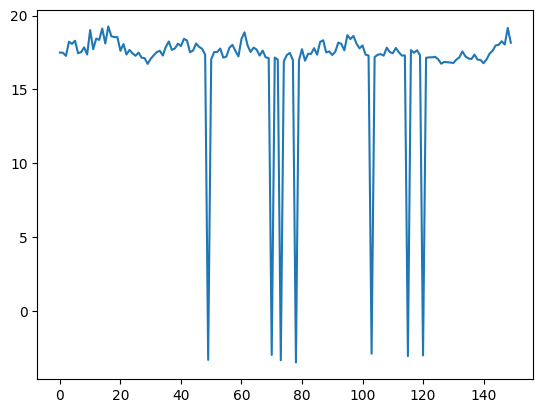

In [202]:
plt.plot(Y)
print(Y.max())

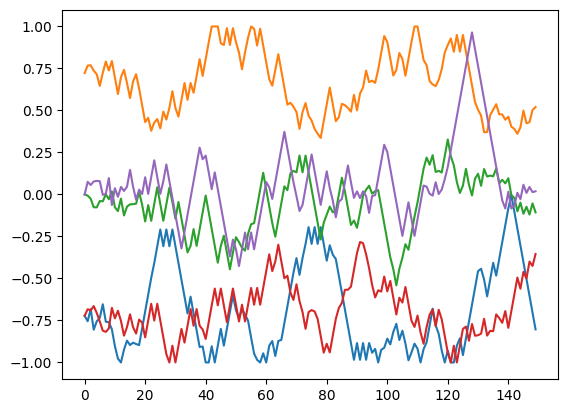

In [203]:
plt.plot(X)

## Try Evaluation